# Build a Question/Answering system over SQL data

:::info Prerequisites

This guide assumes familiarity with the following concepts:

- [Chat models](/docs/concepts/chat_models)
- [Tools](/docs/concepts/tools)
- [Agents](/docs/concepts/agents)
- [LangGraph](/docs/concepts/architecture/#langgraph)

:::

Enabling a LLM system to query structured data can be qualitatively different from unstructured text data. Whereas in the latter it is common to generate text that can be searched against a vector database, the approach for structured data is often for the LLM to write and execute queries in a DSL, such as SQL. In this guide we'll go over the basic ways to create a Q&A system over tabular data in databases. We will cover implementations using both [chains](/docs/tutorials/sql_qa#chains) and [agents](/docs/tutorials/sql_qa#agents). These systems will allow us to ask a question about the data in a database and get back a natural language answer. The main difference between the two is that our agent can query the database in a loop as many times as it needs to answer the question.

## ⚠️ Security note ⚠️

Building Q&A systems of SQL databases requires executing model-generated SQL queries. There are inherent risks in doing this. Make sure that your database connection permissions are always scoped as narrowly as possible for your chain/agent's needs. This will mitigate though not eliminate the risks of building a model-driven system. For more on general security best practices, [see here](/docs/security).


## Architecture

At a high-level, the steps of these systems are:

1. **Convert question to SQL query**: Model converts user input to a SQL query.
2. **Execute SQL query**: Execute the query.
3. **Answer the question**: Model responds to user input using the query results.

Note that querying data in CSVs can follow a similar approach. See our [how-to guide](/docs/how_to/sql_csv) on question-answering over CSV data for more detail.

![sql_usecase.png](../../static/img/sql_usecase.png)

## Setup

First, get required packages and set environment variables:

In [ ]:
%%capture --no-stderr
%pip install --upgrade --quiet langchain-community langchainhub langgraph

```python
# Comment out the below to opt-out of using LangSmith in this notebook. Not required.
if not os.environ.get("LANGCHAIN_API_KEY"):
    os.environ["LANGCHAIN_API_KEY"] = getpass.getpass()
    os.environ["LANGCHAIN_TRACING_V2"] = "true"
```

### Sample data

The below example will use a SQLite connection with the Chinook database, which is a sample database that represents a digital media store. Follow [these installation steps](https://database.guide/2-sample-databases-sqlite/) to create `Chinook.db` in the same directory as this notebook. You can also download and build the database via the command line:
```bash
curl -s https://raw.githubusercontent.com/lerocha/chinook-database/master/ChinookDatabase/DataSources/Chinook_Sqlite.sql | sqlite3 Chinook.db
```

Now, `Chinook.db` is in our directory and we can interface with it using the SQLAlchemy-driven `SQLDatabase` class:

In [2]:
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///Chinook.db")
print(db.dialect)
print(db.get_usable_table_names())
db.run("SELECT * FROM Artist LIMIT 10;")

sqlite
['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track']


"[(1, 'AC/DC'), (2, 'Accept'), (3, 'Aerosmith'), (4, 'Alanis Morissette'), (5, 'Alice In Chains'), (6, 'Antônio Carlos Jobim'), (7, 'Apocalyptica'), (8, 'Audioslave'), (9, 'BackBeat'), (10, 'Billy Cobham')]"

Great! We've got a SQL database that we can query. Now let's try hooking it up to an LLM.

## Chains {#chains}

Chains are compositions of predictable steps. In [LangGraph](/docs/concepts/architecture/#langgraph), we can represent a chain via simple sequence of nodes. Let's create a sequence of steps that, given a question, does the following:
- converts the question into a SQL query;
- executes the query;
- uses the result to answer the original question.

There are scenarios not supported by this arrangement. For example, this system will execute a SQL query for any user input-- even "hello". Importantly, as we'll see below, some questions require more than one query to answer. We will address these scenarios in the Agents section.

### Application state

The LangGraph [state](https://langchain-ai.github.io/langgraph/concepts/low_level/#state) of our application controls what data is input to the application, transferred between steps, and output by the application. It is typically a `TypedDict`, but can also be a [Pydantic BaseModel](https://langchain-ai.github.io/langgraph/how-tos/state-model/).

For this application, we can just keep track of the input question, generated query, query result, and generated answer:

In [3]:
from typing_extensions import TypedDict


class State(TypedDict):
    question: str
    query: str
    result: str
    answer: str

Now we just need functions that operate on this state and populate its contents.

### Convert question to SQL query

The first step is to take the user input and convert it to a SQL query. To reliably obtain SQL queries (absent markdown formatting and explanations or clarifications), we will make use of LangChain's [structured output](/docs/concepts/structured_outputs/) abstraction.

Let's select a chat model for our application:

import ChatModelTabs from "@theme/ChatModelTabs";

<ChatModelTabs customVarName="llm" />


In [4]:
# | output: false
# | echo: false

from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o", temperature=0)

We will pull a prompt from the [Prompt Hub](https://smith.langchain.com/hub) to instruct the model.

In [5]:
from langchain import hub

query_prompt_template = hub.pull("langchain-ai/sql-query-system-prompt")

assert len(query_prompt_template.messages) == 1
query_prompt_template.messages[0].pretty_print()

================================ System Message ================================

Given an input question, create a syntactically correct {dialect} query to run to help find the answer. Unless the user specifies in his question a specific number of examples they wish to obtain, always limit your query to at most {top_k} results. You can order the results by a relevant column to return the most interesting examples in the database.

Never query for all the columns from a specific table, only ask for a the few relevant columns given the question.

Pay attention to use only the column names that you can see in the schema description. Be careful to not query for columns that do not exist. Also, pay attention to which column is in which table.

Only use the following tables:
{table_info}

Question: {input}


The prompt includes several parameters we will need to populate, such as the SQL dialect and table schemas. LangChain's [SQLDatabase](https://python.langchain.com/api_reference/community/utilities/langchain_community.utilities.sql_database.SQLDatabase.html) object includes methods to help with this. Our `write_query` step will just populate these parameters and prompt a model to generate the SQL query:

In [6]:
from typing_extensions import Annotated


class QueryOutput(TypedDict):
    """Generated SQL query."""

    query: Annotated[str, ..., "Syntactically valid SQL query."]


def write_query(state: State):
    """Generate SQL query to fetch information."""
    prompt = query_prompt_template.invoke(
        {
            "dialect": db.dialect,
            "top_k": 10,
            "table_info": db.get_table_info(),
            "input": state["question"],
        }
    )
    structured_llm = llm.with_structured_output(QueryOutput)
    result = structured_llm.invoke(prompt)
    return {"query": result["query"]}

Let's test it out:

In [7]:
write_query({"question": "How many Employees are there?"})

{'query': 'SELECT COUNT(EmployeeId) AS EmployeeCount FROM Employee;'}

### Execute query

**This is the most dangerous part of creating a SQL chain.** Consider carefully if it is OK to run automated queries over your data. Minimize the database connection permissions as much as possible. Consider adding a human approval step to you chains before query execution (see below).

To execute the query, we will load a tool from [langchain-community](/docs/concepts/architecture/#langchain-community). Our `execute_query` node will just wrap this tool:

In [8]:
from langchain_community.tools.sql_database.tool import QuerySQLDatabaseTool


def execute_query(state: State):
    """Execute SQL query."""
    execute_query_tool = QuerySQLDatabaseTool(db=db)
    return {"result": execute_query_tool.invoke(state["query"])}

Testing this step:

In [9]:
execute_query({"query": "SELECT COUNT(EmployeeId) AS EmployeeCount FROM Employee;"})

{'result': '[(8,)]'}

### Generate answer

Finally, our last step generates an answer to the question given the information pulled from the database:

In [10]:
def generate_answer(state: State):
    """Answer question using retrieved information as context."""
    prompt = (
        "Given the following user question, corresponding SQL query, "
        "and SQL result, answer the user question.\n\n"
        f'Question: {state["question"]}\n'
        f'SQL Query: {state["query"]}\n'
        f'SQL Result: {state["result"]}'
    )
    response = llm.invoke(prompt)
    return {"answer": response.content}

### Orchestrating with LangGraph

Finally, we compile our application into a single `graph` object. In this case, we are just connecting the three steps into a single sequence.

In [11]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence(
    [write_query, execute_query, generate_answer]
)
graph_builder.add_edge(START, "write_query")
graph = graph_builder.compile()

LangGraph also comes with built-in utilities for visualizing the control flow of your application:

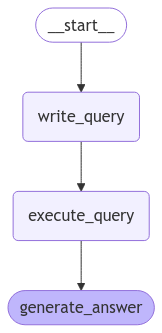

In [12]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

Let's test our application! Note that we can stream the results of individual steps:

In [13]:
for step in graph.stream(
    {"question": "How many employees are there?"}, stream_mode="updates"
):
    print(step)

{'write_query': {'query': 'SELECT COUNT(EmployeeId) AS EmployeeCount FROM Employee;'}}
{'execute_query': {'result': '[(8,)]'}}
{'generate_answer': {'answer': 'There are 8 employees.'}}


Check out the [LangSmith trace](https://smith.langchain.com/public/30a79380-6ba6-46af-8bd9-5d1df0b9ccca/r).

### Human-in-the-loop

LangGraph supports a number of features that can be useful for this workflow. One of them is [human-in-the-loop](https://langchain-ai.github.io/langgraph/concepts/human_in_the_loop/): we can interrupt our application before sensitive steps (such as the execution of a SQL query) for human review. This is enabled by LangGraph's [persistence](https://langchain-ai.github.io/langgraph/concepts/persistence/) layer, which saves run progress to your storage of choice. Below, we specify storage in-memory:

In [14]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory, interrupt_before=["execute_query"])

# Now that we're using persistence, we need to specify a thread ID
# so that we can continue the run after review.
config = {"configurable": {"thread_id": "1"}}

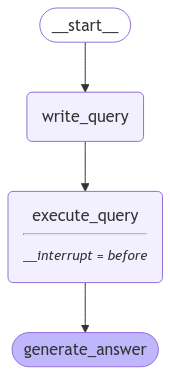

In [15]:
display(Image(graph.get_graph().draw_mermaid_png()))

Let's repeat the same run, adding in a simple yes/no approval step:

In [16]:
for step in graph.stream(
    {"question": "How many employees are there?"},
    config,
    stream_mode="updates",
):
    print(step)

try:
    user_approval = input("Do you want to go to execute query? (yes/no): ")
except Exception:
    user_approval = "no"

if user_approval.lower() == "yes":
    # If approved, continue the graph execution
    for step in graph.stream(None, config, stream_mode="updates"):
        print(step)
else:
    print("Operation cancelled by user.")

{'write_query': {'query': 'SELECT COUNT(EmployeeId) AS EmployeeCount FROM Employee;'}}
{'__interrupt__': ()}


Do you want to go to execute query? (yes/no):  yes


{'execute_query': {'result': '[(8,)]'}}
{'generate_answer': {'answer': 'There are 8 employees.'}}


See [this](https://langchain-ai.github.io/langgraph/concepts/human_in_the_loop/) LangGraph guide for more detail and examples.

### Next steps

For more complex query-generation, we may want to create few-shot prompts or add query-checking steps. For advanced techniques like this and more check out:

* [Prompting strategies](/docs/how_to/sql_prompting): Advanced prompt engineering techniques.
* [Query checking](/docs/how_to/sql_query_checking): Add query validation and error handling.
* [Large databases](/docs/how_to/sql_large_db): Techniques for working with large databases.

## Agents {#agents}

[Agents](/docs/concepts/agents) leverage the reasoning capabilities of LLMs to make decisions during execution. Using agents allows you to offload additional discretion over the query generation and execution process. Although their behavior is less predictable than the above "chain", they feature some advantages:

- They can query the database as many times as needed to answer the user question.
- They can recover from errors by running a generated query, catching the traceback and regenerating it correctly.
- They can answer questions based on the databases' schema as well as on the databases' content (like describing a specific table).


Below we assemble a minimal SQL agent. We will equip it with a set of tools using LangChain's [SQLDatabaseToolkit](https://python.langchain.com/api_reference/community/agent_toolkits/langchain_community.agent_toolkits.sql.toolkit.SQLDatabaseToolkit.html). Using LangGraph's [pre-built ReAct agent constructor](https://langchain-ai.github.io/langgraph/how-tos/#langgraph.prebuilt.chat_agent_executor.create_react_agent), we can do this in one line.

:::tip

Check out LangGraph's [SQL Agent Tutorial](https://langchain-ai.github.io/langgraph/tutorials/sql-agent/) for a more advanced formulation of a SQL agent.

:::

The `SQLDatabaseToolkit` includes tools that can:

* Create and execute queries
* Check query syntax
* Retrieve table descriptions
* ... and more

In [17]:
from langchain_community.agent_toolkits import SQLDatabaseToolkit

toolkit = SQLDatabaseToolkit(db=db, llm=llm)

tools = toolkit.get_tools()

tools

[QuerySQLDatabaseTool(description="Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.", db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x10d5f9120>),
 InfoSQLDatabaseTool(description='Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3', db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x10d5f9120>),
 ListSQLDatabaseTool(db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x10d5f9120>),
 QuerySQLCheckerTool(description='Use this tool to double check if your 

### System Prompt

We will also want to load a system prompt for our agent. This will consist of instructions for how to behave.

In [18]:
from langchain import hub

prompt_template = hub.pull("langchain-ai/sql-agent-system-prompt")

assert len(prompt_template.messages) == 1
prompt_template.messages[0].pretty_print()

================================ System Message ================================

You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct {dialect} query to run, then look at the results of the query and return the answer.
Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most {top_k} results.
You can order the results by a relevant column to return the most interesting examples in the database.
Never query for all the columns from a specific table, only ask for the relevant columns given the question.
You have access to tools for interacting with the database.
Only use the below tools. Only use the information returned by the below tools to construct your final answer.
You MUST double check your query before executing it. If you get an error while executing a query, rewrite the query and try again.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to th

Let's populate the parameters highlighted in the prompt:

In [19]:
system_message = prompt_template.format(dialect="SQLite", top_k=5)

### Initializing agent

We will use a prebuilt [LangGraph](/docs/concepts/architecture/#langgraph) agent to build our agent

In [20]:
from langchain_core.messages import HumanMessage
from langgraph.prebuilt import create_react_agent

agent_executor = create_react_agent(llm, tools, state_modifier=system_message)

Consider how the agent responds to the below question:

In [21]:
question = "Which country's customers spent the most?"

for step in agent_executor.stream(
    {"messages": [{"role": "user", "content": question}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Which country's customers spent the most?
================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (call_tFp7HYD6sAAmCShgeqkVZH6Q)
 Call ID: call_tFp7HYD6sAAmCShgeqkVZH6Q
  Args:
================================= Tool Message =================================
Name: sql_db_list_tables

Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (call_KJZ1Jx6JazyDdJa0uH1UeiOz)
 Call ID: call_KJZ1Jx6JazyDdJa0uH1UeiOz
  Args:
    table_names: Customer, Invoice
================================= Tool Message =================================
Name: sql_db_schema


CREATE TABLE "Customer" (
	"CustomerId" INTEGER NOT NULL, 
	"FirstName" NVARCHAR(40) NOT NULL, 
	"LastName" NVARCHAR(20) NOT NULL, 
	"Company"

You can also use the [LangSmith trace](https://smith.langchain.com/public/8af422aa-b651-4bfe-8683-e2a7f4ccd82c/r) to visualize these steps and associated metadata.

Note that the agent executes multiple queries until it has the information it needs:
1. List available tables;
2. Retrieves the schema for three tables;
3. Queries multiple of the tables via a join operation.

The agent is then able to use the result of the final query to generate an answer to the original question.

The agent can similarly handle qualitative questions:

In [22]:
question = "Describe the playlisttrack table"

for step in agent_executor.stream(
    {"messages": [{"role": "user", "content": question}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Describe the playlisttrack table
================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (call_fMF8eTmX5TJDJjc3Mhdg52TI)
 Call ID: call_fMF8eTmX5TJDJjc3Mhdg52TI
  Args:
================================= Tool Message =================================
Name: sql_db_list_tables

Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (call_W8Vkk4NEodkAAIg8nexAszUH)
 Call ID: call_W8Vkk4NEodkAAIg8nexAszUH
  Args:
    table_names: PlaylistTrack
================================= Tool Message =================================
Name: sql_db_schema


CREATE TABLE "PlaylistTrack" (
	"PlaylistId" INTEGER NOT NULL, 
	"TrackId" INTEGER NOT NULL, 
	PRIMARY KEY ("PlaylistId", "TrackId"), 
	FOREIGN KEY("TrackI

### Dealing with high-cardinality columns

In order to filter columns that contain proper nouns such as addresses, song names or artists, we first need to double-check the spelling in order to filter the data correctly. 

We can achieve this by creating a vector store with all the distinct proper nouns that exist in the database. We can then have the agent query that vector store each time the user includes a proper noun in their question, to find the correct spelling for that word. In this way, the agent can make sure it understands which entity the user is referring to before building the target query.

First we need the unique values for each entity we want, for which we define a function that parses the result into a list of elements:

In [24]:
import ast
import re


def query_as_list(db, query):
    res = db.run(query)
    res = [el for sub in ast.literal_eval(res) for el in sub if el]
    res = [re.sub(r"\b\d+\b", "", string).strip() for string in res]
    return list(set(res))


artists = query_as_list(db, "SELECT Name FROM Artist")
albums = query_as_list(db, "SELECT Title FROM Album")
albums[:5]

['In Through The Out Door',
 'Transmission',
 'Battlestar Galactica (Classic), Season',
 'A Copland Celebration, Vol. I',
 'Quiet Songs']

Using this function, we can create a **retriever tool** that the agent can execute at its discretion.

Let's select an [embeddings model](/docs/integrations/text_embedding/) and [vector store](/docs/integrations/vectorstores/) for this step:

**Select an embedding model**:

import EmbeddingTabs from "@theme/EmbeddingTabs";

<EmbeddingTabs/>

In [25]:
# | output: false
# | echo: false

from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings()

**Select a vector store**:

import VectorStoreTabs from "@theme/VectorStoreTabs";

<VectorStoreTabs/>

In [26]:
# | output: false
# | echo: false

from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)

We can now construct a retrieval tool that can search over relevant proper nouns in the database:

In [27]:
from langchain.agents.agent_toolkits import create_retriever_tool

_ = vector_store.add_texts(artists + albums)
retriever = vector_store.as_retriever(search_kwargs={"k": 5})
description = (
    "Use to look up values to filter on. Input is an approximate spelling "
    "of the proper noun, output is valid proper nouns. Use the noun most "
    "similar to the search."
)
retriever_tool = create_retriever_tool(
    retriever,
    name="search_proper_nouns",
    description=description,
)

Let's try it out:

In [28]:
print(retriever_tool.invoke("Alice Chains"))

Alice In Chains

Alanis Morissette

Pearl Jam

Pearl Jam

Audioslave


This way, if the agent determines it needs to write a filter based on an artist along the lines of "Alice Chains", it can first use the retriever tool to observe relevant values of a column.

Putting this together:

In [31]:
# Add to system message
suffix = (
    "If you need to filter on a proper noun like a Name, you must ALWAYS first look up "
    "the filter value using the 'search_proper_nouns' tool! Do not try to "
    "guess at the proper name - use this function to find similar ones."
)

system = f"{system_message}\n\n{suffix}"

tools.append(retriever_tool)

agent = create_react_agent(llm, tools, state_modifier=system)

In [34]:
question = "How many albums does alis in chain have?"

for step in agent.stream(
    {"messages": [{"role": "user", "content": question}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

How many albums does alis in chain have?
================================== Ai Message ==================================
Tool Calls:
  search_proper_nouns (call_8ryjsRPLAr79mM3Qvnq6gTOH)
 Call ID: call_8ryjsRPLAr79mM3Qvnq6gTOH
  Args:
    query: alis in chain
================================= Tool Message =================================
Name: search_proper_nouns

Alice In Chains

Aisha Duo

Xis

Da Lama Ao Caos

A-Sides
================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (call_NJjtCpU89MBMplssjn1z0xzq)
 Call ID: call_NJjtCpU89MBMplssjn1z0xzq
  Args:
  search_proper_nouns (call_1BfrueC9koSIyi4OfMu2Ao8q)
 Call ID: call_1BfrueC9koSIyi4OfMu2Ao8q
  Args:
    query: Alice In Chains
================================= Tool Message =================================
Name: search_proper_nouns

Alice In Chains

Pearl Jam

Pearl Jam

Foo Fighters

Soundga

As we can see, both in the streamed steps and in the [LangSmith trace](https://smith.langchain.com/public/1d757ed2-5688-4458-9400-023594e2c5a7/r), the agent used the `search_proper_nouns` tool in order to check how to correctly query the database for this specific artist.